This script is used for RT analysis for the rule-based condition in section:
"Rule- and stimulus-based biases had different effects on choices and RTs"

In [1]:
#clear memory
rm(list=ls())

## loading data/libraries ##

#load libraries
library(lme4)
#library(plyr)
library(dplyr)
#library(tidyr)
library(car)
library(lmerTest)
library(emmeans)
#library(afex)
emm_options(lmerTest.limit = 22676)
library(lattice)
library(ggplot2)

se <- function(x) sqrt(var(x) / length(x))

switch(Sys.info()[['sysname']],
       Windows = PROJECT_DIR <- paste0('C:/Users/',Sys.getenv('USERNAME'),
                              '/Dropbox/Goldlab/AuditoryPriors/'),
       Darwin = PROJECT_DIR <- '~/Dropbox/Goldlab/AuditoryPriors/'
)

DATA_DIR = paste0(PROJECT_DIR,'FitGDDM/data/')
setwd(paste0(PROJECT_DIR,'data processing'))


DATA_FILE = 'priorOnly_28-Jan-2020.csv'

pt_df <- read.table(paste0(DATA_DIR,DATA_FILE),sep=',', header=TRUE, 
                    stringsAsFactors=FALSE,na.strings = 'NaN')

#remove missing trials
pt_df <- subset(pt_df,!is.na(choice01) & !is.na(RT))

Loading required package: Matrix

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'car' was built under R version 4.0.4"
Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Warning message:
"package 'lmerTest' was built under R version 4.0.4"

Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

 

In [2]:
#set up factors
my_simple3<-contr.treatment(3,base=3) - matrix(rep(1/3,6),ncol=2)
pt_df$prior.f <- factor(pt_df$prior,levels=c(-2,2,0),labels=c('low','high','no'))
pt_df$prior.fs <- pt_df$prior.f
pt_df$prior.fs2 <- factor(pt_df$prior.fs,levels=c('no','low','high'))
contrasts(pt_df$prior.f) <- my_simple3
contrasts(pt_df$prior.fs) <- contr.sum(3)
contrasts(pt_df$prior.fs2) <- contr.sum(3)
contrasts(pt_df$prior.f) 
contrasts(pt_df$prior.fs) 
contrasts(pt_df$prior.fs2) 

my_simple2<-contr.treatment(2,base=2) - matrix(rep(1/2,2))
pt_df$isH.f <- factor(pt_df$isH,levels=c(1,0),labels=c("H","L"))
pt_df$isH.fs <- pt_df$isH.f
contrasts(pt_df$isH.f) <- my_simple2
contrasts(pt_df$isH.fs) <- contr.sum(2)
contrasts(pt_df$isH.f)
contrasts(pt_df$isH.fs)


#set up variables
pt_df$aSNR <- abs(pt_df$SNR)

## Correct RT only
pt_dfc <- subset(pt_df,success==1)


## now compute medians for analysis
pt_dfc.med <- summarise(group_by(pt_dfc,subject,aSNR,isH,prior),RT=median(RT))


,1,2
low,0.6666667,-0.3333333
high,-0.3333333,0.6666667
no,-0.3333333,-0.3333333


low,1,0
high,0,1
no,-1,-1


no,1,0
low,0,1
high,-1,-1


,1
H,0.5
L,-0.5


H,1
L,-1


`summarise()` regrouping output by 'subject', 'aSNR', 'isH' (override with `.groups` argument)



In [3]:
#set up factors
my_simple2<-contr.treatment(2,base=2) - matrix(rep(1/2,2))
pt_dfc.med$isH.f <- factor(pt_dfc.med$isH,levels=c(1,0),labels=c("H","L"))
pt_dfc.med$isH.fs <- pt_dfc.med$isH.f
contrasts(pt_dfc.med$isH.f) <- my_simple2
contrasts(pt_dfc.med$isH.fs) <- contr.sum(2)
contrasts(pt_dfc.med$isH.f)
contrasts(pt_dfc.med$isH.fs)

# WARNING: THIS IS CONGRUENT WITH STIM! Doesn't matter if only analyzing correct RT but beware!!!
pt_dfc.med$congruent <- 
  (pt_dfc.med$prior==2 & pt_dfc.med$isH==1) | (pt_dfc.med$prior==-2 & pt_dfc.med$isH==0)
pt_dfc.med$congruent[pt_dfc.med$prior==0] = -1

pt_dfc.med$congruent.fs <- factor(pt_dfc.med$congruent,levels=c(1,0,-1),
                            labels=c("congruent","incongruent","no prior"))
contrasts(pt_dfc.med$congruent.fs) <- contr.sum(3)
contrasts(pt_dfc.med$congruent.fs)

#set up variables
pt_dfc.med$RTms <- pt_dfc.med$RT/1000
pt_dfc.med$zaSNR <- scale(pt_dfc.med$aSNR)


,1
H,0.5
L,-0.5


H,1
L,-1


congruent,1,0
incongruent,0,1
no prior,-1,-1


## congruency model

In [4]:
pt_dfc.med[,c('congruent.fs1','congruent.fs2')] <- 
  model.matrix(~1+pt_dfc.med$congruent.fs,pt_dfc.med)[,2:3]
#let's simplify and just ask about congruency effects

In [5]:
#full model
rtccon.lm.0 <- lmer(RT~zaSNR + congruent.fs + (1+zaSNR + congruent.fs|subject), 
                 data=pt_dfc.med, 
                 control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

boundary (singular) fit: see ?isSingular

Warning message:
"Model failed to converge with 1 negative eigenvalue: -1.7e+01"


In [6]:
#FINAL
#zero corr model converges
rtccon.lm.0nc <- lmer(RT~zaSNR + congruent.fs + (1+zaSNR + congruent.fs1 + congruent.fs2||subject), 
                    data=pt_dfc.med, 
                    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

In [7]:
#FINAL

Anova(rtccon.lm.0nc,test.statistic = "F")

rtccon.lm.0nc.emm <- emmeans(rtccon.lm.0nc,specs = ~congruent.fs)
rtccon.lm.0nc.pairs <- pairs(rtccon.lm.0nc.emm,adjust="holm")
rtccon.lm.0nc.pairs

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
zaSNR,75.56664,1,48.01616,2.011075e-11
congruent.fs,160.43164,2,65.08311,6.973780e-26


 contrast                estimate   SE    df t.ratio p.value
 congruent - incongruent   -128.2 7.21 226.3 -17.783 <.0001 
 congruent - no prior       -75.5 8.21  51.0  -9.191 <.0001 
 incongruent - no prior      52.7 8.73  49.3   6.038 <.0001 

Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 3 tests 

In [8]:
#FINAL
summary(rtccon.lm.0nc.pairs,adjust="holm")

,contrast,estimate,SE,df,t.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,congruent - incongruent,-128.16665,7.207237,226.27306,-17.783051,2.242342e-44
2,congruent - no prior,-75.47899,8.212368,51.03370,-9.190892,4.197273e-12
3,incongruent - no prior,52.68767,8.725318,49.30212,6.038481,1.999749e-07


### generate predictions for plotting

In [9]:
#FINAL

pt_dfc.med$RT_pred <- predict(rtccon.lm.0nc) #with rfx

In [10]:
#FINAL

#plot against medians
pt_dfc.med$prior.f <- factor(pt_dfc.med$prior,levels=c(-2,2,0),labels=c('low','high','no'))
pred_ave.med_all <- summarise(group_by(pt_dfc.med,aSNR,isH,prior.f,prior),RT_sem=se(RT),RT=mean(RT),
                              RT_pred=mean(RT_pred))#,RT_pred_rfx=mean(RT_pred_rfx))
pred_ave.med_all$SNR <- pred_ave.med_all$aSNR *(pred_ave.med_all$isH*2-1)

`summarise()` regrouping output by 'aSNR', 'isH', 'prior.f' (override with `.groups` argument)



In [12]:
#output for matlab plotting
if (F) {
    write.csv(pred_ave.med_all,paste0('./precue_RT_pred_',Sys.Date(),'.csv'),row.names=F)
}

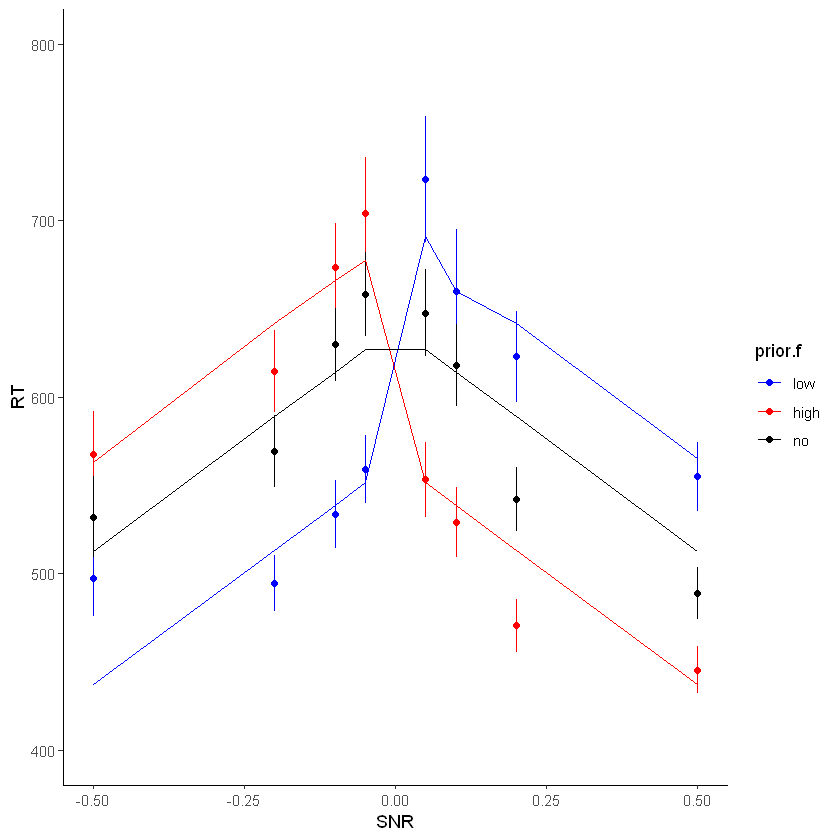

In [13]:
ggplot(pred_ave.med_all, aes(x=SNR, y=RT, colour=prior.f)) + 
    geom_errorbar(aes(ymin=RT-RT_sem, ymax=RT+RT_sem), width=0) +
    geom_point() +
    geom_line(aes(x=SNR, y=RT_pred, colour=prior.f)) +
    ylim(c(400,800)) + 
    scale_color_manual(values=c("blue", "red", "black")) +
    theme_classic()